# Hello distributed world

The goal of this tutorial is to setup a simulation and run it by using minimal example.

In [1]:
# If pydistsim is not installed and the script is run from docs/notebooks directory
import sys

sys.path.append("../../")

from pydistsim import NetworkGenerator, Simulation, enable_logger
from pydistsim.logger import set_log_level, LogLevels

set_log_level("WARNING")


# Create a network with 100 nodes
net_gen = NetworkGenerator(100, directed=False)
net = net_gen.generate_random_network()

# Assign a simple algorithm to the network
from pydistsim.demo_algorithms.broadcast import Flood

sim = Simulation(net)

sim.algorithms = ((Flood, {"informationKey": "I"}),)
some_node = tuple(net.nodes())[0]
some_node.memory["I"] = "Hello distributed world"

# Create and run the simulation
sim.run()

That's it! For more elaborate description please continue reading.

In [2]:
# For more detailed output, set the log level to INFO
set_log_level(LogLevels.INFO)
enable_logger()

In the example given above, the goal was to simulate distributed algorithm `Flood` on arbitrary network. Algorithm `Flood` solves *Broadcast* problem, i.e. the goal of the algorithm is to share information that is present in one or more nodes to all other nodes in the network.

In this example the IPython interactive console is started with `ipydistsim` or `ipython --profile=pydistsim`. This way certain names from PyDistSim package should already be available such as `Node` or `Network`.

### Generating network

Networks are fundamental objects in the PyDistSim and they can be created by instantiating `Network` class or by using  `NetworkGenerator` class. `NetworkGenerator` can receive different parameters such as number of nodes (exact, min, max), average number of neighbors per node etc.

In this example the only parametar that we want to have in control is number of nodes. which is set to 100.

In [3]:
net_gen = NetworkGenerator(100, directed=False)

Now generator's methods can be used to generate new networks with specified parameters, i.e. for generating network with random placement of nodes there is method `generate_random_network()`:

In [4]:
net = net_gen.generate_random_network()

*Note:* One of the `NetworkGenerator` parameters control if the generated network should be connected (which means  there are no isolated segments of the network). This parameter `connected` is by default set to `True` so if the number of nodes is set too low then some generator's methods  might not be able to produce the network.

The result is instance of the Network class:

In [5]:
net

which can be visualized with its `show()` method:

/home/agus/.pymote_venv/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(
/mnt/d/Proyectos/pymote/docs/notebooks/../../pydistsim/network/network.py:537: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


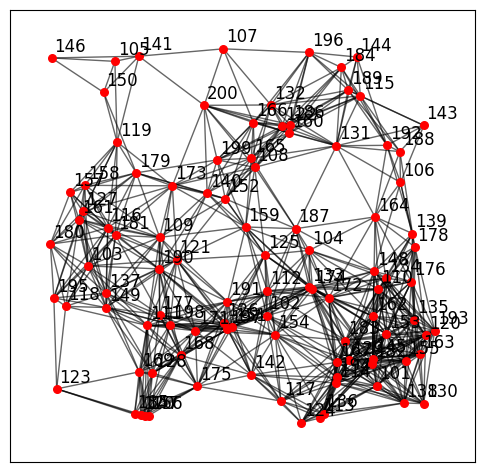

In [6]:
net.show()

In [7]:
sim = Simulation(net)

### Algorithm and Simulation

Implementation of `Flood`:

In [8]:
from pydistsim.algorithm.node_algorithm import NodeAlgorithm, StatusValues
from pydistsim.algorithm.node_wrapper import NodeAccess
from pydistsim.message import Message
from pydistsim.restrictions.communication import BidirectionalLinks
from pydistsim.restrictions.reliability import TotalReliability
from pydistsim.restrictions.topological import Connectivity, UniqueInitiator


class Flood(NodeAlgorithm):
    default_params = {"informationKey": "information", "initial_information": "Hello world!"}

    class Status(StatusValues):
        INITIATOR = "INITIATOR"
        IDLE = "IDLE"
        DONE = "DONE"

    S_init = (Status.INITIATOR, Status.IDLE)
    S_term = (Status.DONE,)

    algorithm_restrictions = (
        BidirectionalLinks,
        TotalReliability,
        Connectivity,
        UniqueInitiator,
    )

    def initializer(self):
        for node in self.network.nodes():
            node.status = self.Status.IDLE

        ini_node = self.network.nodes_sorted()[0]
        ini_node.push_to_inbox(Message(meta_header=NodeAlgorithm.INI, destination=ini_node))
        ini_node.status = self.Status.INITIATOR
        ini_node.memory[self.informationKey] = self.initial_information

    @Status.INITIATOR
    def spontaneously(self, node: NodeAccess, message: Message):
        self.send(
            node,
            content=node.memory[self.informationKey],
            destination=list(node.neighbors()),
            header="Information",
        )
        node.status = self.Status.DONE

    @Status.IDLE
    def receiving(self, node: NodeAccess, message: Message):
        if message.header == "Information":
            node.memory[self.informationKey] = message.data
            destination_nodes = node.neighbors()
            # send to every neighbor, except the original sender
            destination_nodes.remove(message.source)

            if destination_nodes:
                self.send(
                    node,
                    destination=destination_nodes,
                    header="Information",
                    data=message.data,
                )
        node.status = self.Status.DONE

    @Status.DONE
    def default(self, *args, **kwargs):
        "Do nothing, for all inputs."
        pass

#### Assingning algorithm to the simulation

Two things should be noted:

* there can be multiple algorithms that are being assigned to the simulation so specific algorithms are elements of `tuple`. Since in this example there is only one algorithm we must append `,` so that Python knows it's a one element `tuple` i.e. `(1)` is `int`, but `(1,)` is `tuple`.
* every algorithm element is `tuple` itself, consisting of two elements. Former is an algorithm class, in this example `Flood`. Later is a `dict` of keyword parameters, i.e. `Flood` must be given 'informationKey' as a required parameter: that is the name of the key under which the nodes should store broadcasted information in their memory.

In [9]:
sim = Simulation(net)
INF_KEY = "I"
MESSAGE = "Hello distributed world"
sim.algorithms = ((Flood, {"informationKey": INF_KEY, "initial_information": MESSAGE}),)

### Running

Finally, run simulation:

In [10]:
sim.run()

After the algorithm(s) execution is done we can check if the resullt is as expected, that is every node should have information in their memory:

In [11]:
for node in net.nodes():
    assert node.memory[INF_KEY] == MESSAGE, "Oh..."
print("Everything is OK!")

Everything is OK!


During simulation execution, network and its nodes are changing their status, memory content etc. To memorize the currently running algorithm and current step of the simulation, network has a special attribute `algorithmsState`:

In [12]:
sim.algorithmState

{'index': 0, 'step': 34, 'finished': True}

If simulation is going to be run again, it must be reset:

In [13]:
sim.reset()

whereby:

* `algorithmState` is returned to the initial value:

In [14]:
sim.algorithmState

{'index': 0, 'step': 1, 'finished': False}

* memory content of all node's is deleted (as long as some other attributes)

In [15]:
for node in net.nodes():
    assert len(node.memory) == 0
print("All memories are empty!")

All memories are empty!


In [16]:
sim.run()